# Elo Merchant Category Recommendation
In this tutorial you can solve the [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest with the help of LynxKite. Unfortunately LynxKite does not yet support some of the data preprocessing, thus it needs to be done in Python.

First download the input files from [here](https://www.kaggle.com/c/elo-merchant-category-recommendation/data), unzip them and copy the extracted files to the `input` folder. These files are

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, preprocessing, metrics

warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv("output/train_preprocessed.csv")
df_test = pd.read_csv("output/test_preprocessed.csv")

In [3]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

### LigthGBM

In [7]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71758	valid_1's rmse: 3.78822
[200]	training's rmse: 3.64412	valid_1's rmse: 3.74506
[300]	training's rmse: 3.59312	valid_1's rmse: 3.72297
[400]	training's rmse: 3.55221	valid_1's rmse: 3.71024
[500]	training's rmse: 3.51918	valid_1's rmse: 3.7029
[600]	training's rmse: 3.48984	valid_1's rmse: 3.69763
[700]	training's rmse: 3.46474	valid_1's rmse: 3.69377
[800]	training's rmse: 3.4417	valid_1's rmse: 3.69082
[900]	training's rmse: 3.42144	valid_1's rmse: 3.68873
[1000]	training's rmse: 3.40272	valid_1's rmse: 3.68707
[1100]	training's rmse: 3.38554	valid_1's rmse: 3.6857
[1200]	training's rmse: 3.36906	valid_1's rmse: 3.68444
[1300]	training's rmse: 3.35367	valid_1's rmse: 3.68353
[1400]	training's rmse: 3.3395	valid_1's rmse: 3.68289
[1500]	training's rmse: 3.3257	valid_1's rmse: 3.68206
[1600]	training's rmse: 3.31252	valid_1's rmse: 3.68199
[1700]	training's rmse: 3.29955	valid_1's rmse

In [8]:
val_score = np.sqrt(mean_squared_error(target, oof))
val_score

3.671886418541465

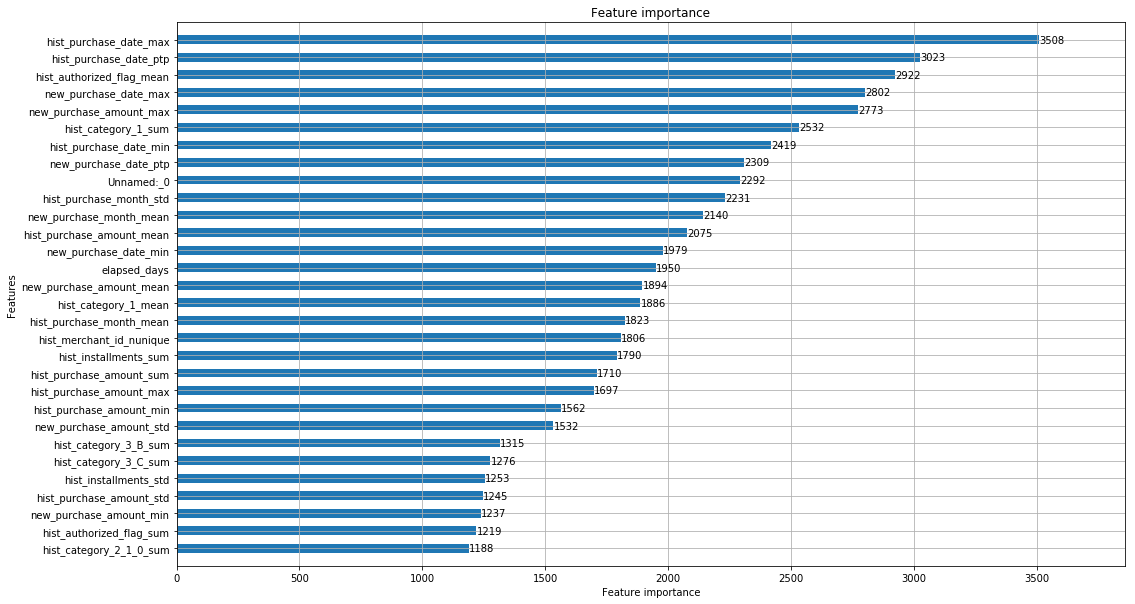

In [15]:
fig, ax = plt.subplots(figsize=(17, 10))
lgb.plot_importance(clf, max_num_features=30, height=0.5, ax=ax, title='Feature importance', xlabel='Feature importance', ylabel='Features')
plt.show()

In [16]:
sorted(list(zip(clf.feature_importance(), features)), reverse=True)

[(3508, 'hist_purchase_date_max'),
 (3023, 'hist_purchase_date_ptp'),
 (2922, 'hist_authorized_flag_mean'),
 (2802, 'new_purchase_date_max'),
 (2773, 'new_purchase_amount_max'),
 (2532, 'hist_category_1_sum'),
 (2419, 'hist_purchase_date_min'),
 (2309, 'new_purchase_date_ptp'),
 (2292, 'Unnamed: 0'),
 (2231, 'hist_purchase_month_std'),
 (2140, 'new_purchase_month_mean'),
 (2075, 'hist_purchase_amount_mean'),
 (1979, 'new_purchase_date_min'),
 (1950, 'elapsed_days'),
 (1894, 'new_purchase_amount_mean'),
 (1886, 'hist_category_1_mean'),
 (1823, 'hist_purchase_month_mean'),
 (1806, 'hist_merchant_id_nunique'),
 (1790, 'hist_installments_sum'),
 (1710, 'hist_purchase_amount_sum'),
 (1697, 'hist_purchase_amount_max'),
 (1562, 'hist_purchase_amount_min'),
 (1532, 'new_purchase_amount_std'),
 (1315, 'hist_category_3_B_sum'),
 (1276, 'hist_category_3_C_sum'),
 (1253, 'hist_installments_std'),
 (1245, 'hist_purchase_amount_std'),
 (1237, 'new_purchase_amount_min'),
 (1219, 'hist_authorized_flag

### Ridge regression

In [5]:
oof_ridge = np.zeros(df_train.shape[0])
predictions_ridge = np.zeros(df_test.shape[0])

tst_data = df_test.copy()
tst_data.fillna((tst_data.mean()), inplace=True)

tst_data = tst_data[features].values

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['outliers'].values)):
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("Fold {}".format(fold_ + 1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values

    clf = Ridge(alpha=100)
    clf.fit(trn_data, trn_y)
    
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(tst_data) / folds.n_splits

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
val_score = np.sqrt(mean_squared_error(target, oof_ridge))
val_score

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
lgb.plot_importance(clf, max_num_features=30, height=0.5, ax=ax, title='Feature importance', xlabel='Feature importance', ylabel='Features')
plt.show()